## Stable Diffusion (Text to Image) - Finetune with cat images (limited data)

#### Imports 

In [2]:
from sagemaker.jumpstart.notebook_utils import list_jumpstart_models
from sagemaker.utils import name_from_base
from sagemaker.estimator import Estimator
from sagemaker import get_execution_role
from sagemaker import hyperparameters
from sagemaker import script_uris
from sagemaker import image_uris
from sagemaker import model_uris
import matplotlib.pyplot as plt
import numpy as np
import sagemaker
import datetime
import logging
import boto3
import json

##### Setup logging 

In [3]:
logger = logging.getLogger('sagemaker')
logger.setLevel(logging.DEBUG)
logger.addHandler(logging.StreamHandler())

##### Log versions of dependencies 

In [4]:
logger.info(f'[Using SageMaker version: {sagemaker.__version__}]')

[Using SageMaker version: 2.120.0]


#### I. Setup essentials 

In [4]:
ROLE = get_execution_role()
REGION = boto3.Session().region_name
session = sagemaker.Session()
logger.info(f'Region: {REGION}')

Region: eu-central-1


##### List all models from SageMaker JumpStart hub

In [5]:
models = list_jumpstart_models()
len(models)

649

In [6]:
FILTER = 'task == txt2img'
txt2img_models = list_jumpstart_models(filter=FILTER)
txt2img_models

['huggingface-txt2img-22h-vintedois-diffusion-v0-1',
 'huggingface-txt2img-akikagura-mkgen-diffusion',
 'huggingface-txt2img-alxdfy-noggles-fastdb-4800',
 'huggingface-txt2img-alxdfy-noggles9000',
 'huggingface-txt2img-andite-anything-v4-0',
 'huggingface-txt2img-astraliteheart-pony-diffusion-v2',
 'huggingface-txt2img-avrik-abstract-anim-spritesheets',
 'huggingface-txt2img-aybeeceedee-knollingcase',
 'huggingface-txt2img-bingsu-my-k-anything-v3-0',
 'huggingface-txt2img-bingsu-my-korean-stable-diffusion-v1-5',
 'huggingface-txt2img-buntopsih-novgoranstefanovski',
 'huggingface-txt2img-claudfuen-photorealistic-fuen-v1',
 'huggingface-txt2img-coder119-vectorartz-diffusion',
 'huggingface-txt2img-conflictx-complex-lineart',
 'huggingface-txt2img-dallinmackay-cats-musical-diffusion',
 'huggingface-txt2img-dallinmackay-jwst-deep-space-diffusion',
 'huggingface-txt2img-dallinmackay-tron-legacy-diffusion',
 'huggingface-txt2img-dallinmackay-van-gogh-diffusion',
 'huggingface-txt2img-dgspitz

In [7]:
MODEL_ID = 'model-txt2img-stabilityai-stable-diffusion-v2-1-base'
MODEL_VERSION = '*'  # latest
SCOPE = 'training'
TRAIN_INSTANCE_TYPE = 'ml.g4dn.2xlarge'

#### II. Retrieve training artifacts 

In [8]:
train_image_uri = image_uris.retrieve(
    region=REGION, 
    framework=None,
    model_id=MODEL_ID, 
    model_version=MODEL_VERSION, 
    image_scope=SCOPE, 
    instance_type=TRAIN_INSTANCE_TYPE
)

logger.info(f'Training image URI: {train_image_uri}')

image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
Training image URI: 763104351884.dkr.ecr.eu-central-1.amazonaws.com/huggingface-pytorch-training:1.10.2-transformers4.17.0-gpu-py38-cu113-ubuntu20.04


In [9]:
train_source_uri = script_uris.retrieve(model_id=MODEL_ID, 
                                        model_version=MODEL_VERSION, 
                                        script_scope=SCOPE)
logger.info(f'Training source URI: {train_source_uri}')

Training source URI: s3://jumpstart-cache-prod-eu-central-1/source-directory-tarballs/stabilityai/transfer_learning/txt2img/v1.0.3/sourcedir.tar.gz


In [10]:
train_model_uri = model_uris.retrieve(
    model_id=MODEL_ID, 
    model_version=MODEL_VERSION, 
    model_scope=SCOPE
)
logger.info(f'Training model URI: {train_model_uri}')

Training model URI: s3://jumpstart-cache-prod-eu-central-1/stabilityai-training/train-model-txt2img-stabilityai-stable-diffusion-v2-1-base.tar.gz


##### Setup data locations 

In [11]:
DEFAULT_BUCKET = session.default_bucket()
logger.info(f'Default bucket = {DEFAULT_BUCKET}')

Default bucket = sagemaker-eu-central-1-106877348565


In [12]:
TRAIN_DATA_INPUT_PREFIX = 'js-input/cats/'

In [13]:
TRAIN_DATA_INPUT_S3_PATH = f's3://{DEFAULT_BUCKET}/{TRAIN_DATA_INPUT_PREFIX}'
logger.info(f'Training data input S3 location => {TRAIN_DATA_INPUT_S3_PATH}')

Training data input S3 location => s3://sagemaker-eu-central-1-106877348565/js-input/cats/


#### III. Copy dataset for fine-tuning from local to S3

In [14]:
!rm -rf ./data/.ipynb_checkpoints/ 

In [16]:
!aws s3 cp ./data {TRAIN_DATA_INPUT_S3_PATH} --recursive

upload: data/dataset_info.json to s3://sagemaker-us-east-1-119174016168/js-input/cats/dataset_info.json
upload: data/riobugger2.jpeg to s3://sagemaker-us-east-1-119174016168/js-input/cats/riobugger2.jpeg
upload: data/riobugger4.jpeg to s3://sagemaker-us-east-1-119174016168/js-input/cats/riobugger4.jpeg
upload: data/riobugger6.jpeg to s3://sagemaker-us-east-1-119174016168/js-input/cats/riobugger6.jpeg
upload: data/riobugger3.jpeg to s3://sagemaker-us-east-1-119174016168/js-input/cats/riobugger3.jpeg
upload: data/riobugger8.jpeg to s3://sagemaker-us-east-1-119174016168/js-input/cats/riobugger8.jpeg
upload: data/riobugger5.jpeg to s3://sagemaker-us-east-1-119174016168/js-input/cats/riobugger5.jpeg
upload: data/riobugger1.jpeg to s3://sagemaker-us-east-1-119174016168/js-input/cats/riobugger1.jpeg
upload: data/riobugger7.jpeg to s3://sagemaker-us-east-1-119174016168/js-input/cats/riobugger7.jpeg


In [16]:
TRAIN_DATA_OUTPUT_PREFIX = 'js-output'
TRAIN_DATA_OUTPUT_S3_PATH = f's3://{DEFAULT_BUCKET}/{TRAIN_DATA_OUTPUT_PREFIX}'
logger.info(f'Training output S3 location => {TRAIN_DATA_OUTPUT_S3_PATH}')

Training output S3 location => s3://sagemaker-eu-central-1-106877348565/js-output


#### IV. Access and update default hyperparams

In [18]:
hyperparams = hyperparameters.retrieve_default(
    model_id=MODEL_ID, 
    model_version=MODEL_VERSION
)
hyperparams 

{'epochs': '20',
 'max_steps': 'None',
 'batch_size': '1',
 'with_prior_preservation': 'False',
 'num_class_images': '100',
 'learning_rate': '2e-06',
 'prior_loss_weight': '1.0',
 'center_crop': 'False',
 'lr_scheduler': 'constant',
 'adam_weight_decay': '0.01',
 'adam_beta1': '0.9',
 'adam_beta2': '0.999',
 'adam_epsilon': '1e-08',
 'gradient_accumulation_steps': '1',
 'max_grad_norm': '1.0',
 'compute_fid': 'False',
 'seed': '0'}

You can also override these hyperparams 

In [19]:
hyperparams['max_steps'] = '400'
hyperparams['seed'] = '123'
hyperparams

{'epochs': '20',
 'max_steps': '400',
 'batch_size': '1',
 'with_prior_preservation': 'False',
 'num_class_images': '100',
 'learning_rate': '2e-06',
 'prior_loss_weight': '1.0',
 'center_crop': 'False',
 'lr_scheduler': 'constant',
 'adam_weight_decay': '0.01',
 'adam_beta1': '0.9',
 'adam_beta2': '0.999',
 'adam_epsilon': '1e-08',
 'gradient_accumulation_steps': '1',
 'max_grad_norm': '1.0',
 'compute_fid': 'False',
 'seed': '123'}

#### V. Finetune Stable Diffusion model

In [21]:
model_prefix = name_from_base(f'genai-paris-cats-lab2-{MODEL_ID}-')
training_job_name = f'{model_prefix}-finetuning'
logger.info(f'Train job name => {training_job_name}')

Train job name => genai-paris-cats-lab2-model-txt2img-sta-2023-04-03-18-23-53-138-finetuning


In [23]:
MAX_RUN = 360000
estimator = Estimator(
    role=ROLE, 
    image_uri=train_image_uri, 
    source_dir=train_source_uri, 
    model_uri=train_model_uri, 
    entry_point='transfer_learning.py', 
    instance_count=1, 
    instance_type=TRAIN_INSTANCE_TYPE, 
    max_run=MAX_RUN, 
    hyperparameters=hyperparams, 
    output_path=TRAIN_DATA_OUTPUT_S3_PATH, 
    base_job_name=training_job_name
)

In [ ]:
%%time

estimator.fit({'training': TRAIN_DATA_INPUT_S3_PATH}, logs=False)

Creating training-job with name: genai-paris-cats-lab2-model-txt2img-sta-2023-04-03-18-25-24-980
INFO:sagemaker:Creating training-job with name: genai-paris-cats-lab2-model-txt2img-sta-2023-04-03-18-25-24-980
train request: {
    "AlgorithmSpecification": {
        "TrainingInputMode": "File",
        "TrainingImage": "763104351884.dkr.ecr.eu-central-1.amazonaws.com/huggingface-pytorch-training:1.10.2-transformers4.17.0-gpu-py38-cu113-ubuntu20.04"
    },
    "OutputDataConfig": {
        "S3OutputPath": "s3://sagemaker-eu-central-1-106877348565/js-output"
    },
    "TrainingJobName": "genai-paris-cats-lab2-model-txt2img-sta-2023-04-03-18-25-24-980",
    "StoppingCondition": {
        "MaxRuntimeInSeconds": 360000
    },
    "ResourceConfig": {
        "VolumeSizeInGB": 30,
        "InstanceCount": 1,
        "InstanceType": "ml.g4dn.2xlarge"
    },
    "RoleArn": "arn:aws:iam::106877348565:role/service-role/AmazonSageMaker-ExecutionRole-20230120T102711",
    "InputDataConfig": [
     


2023-04-03 18:25:29 Starting - Starting the training job..
2023-04-03 18:25:43 Starting - Preparing the instances for training...........
2023-04-03 18:26:41 Downloading - Downloading input data.................................
2023-04-03 18:29:37 Training - Downloading the training image.................
2023-04-03 18:31:08 Training - Training image download completed. Training in progress.........................................................................................................................................
2023-04-03 18:43:11 Uploading - Uploading generated training model................................................................................................................
2023-04-03 18:52:42 Completed - Training job completed
CPU times: user 1.5 s, sys: 188 ms, total: 1.69 s
Wall time: 27min 18s


#### VI. Deploy fine-tuned model as a SageMaker endpoint

##### Retrieve artifacts for inference 

In [38]:
SCOPE = 'inference'
INFERENCE_INSTANCE_TYPE = 'ml.g4dn.2xlarge'  # prefered

In [39]:
deploy_image_uri = image_uris.retrieve(
    region=REGION, 
    framework=None,  
    image_scope=SCOPE, 
    model_id=MODEL_ID, 
    model_version=MODEL_VERSION, 
    instance_type=INFERENCE_INSTANCE_TYPE
)
logger.info(f'Deploy image URI => {deploy_image_uri}')

Deploy image URI => 763104351884.dkr.ecr.eu-central-1.amazonaws.com/huggingface-pytorch-inference:1.10.2-transformers4.17.0-gpu-py38-cu113-ubuntu20.04
INFO:sagemaker:Deploy image URI => 763104351884.dkr.ecr.eu-central-1.amazonaws.com/huggingface-pytorch-inference:1.10.2-transformers4.17.0-gpu-py38-cu113-ubuntu20.04


In [40]:
deploy_source_uri = script_uris.retrieve(
    model_id=MODEL_ID, 
    model_version=MODEL_VERSION, 
    script_scope=SCOPE
)

logger.info(f'Deploy source URI => {deploy_source_uri}')

Deploy source URI => s3://jumpstart-cache-prod-eu-central-1/source-directory-tarballs/stabilityai/inference/txt2img/v1.2.3/sourcedir.tar.gz
INFO:sagemaker:Deploy source URI => s3://jumpstart-cache-prod-eu-central-1/source-directory-tarballs/stabilityai/inference/txt2img/v1.2.3/sourcedir.tar.gz


In [41]:
current_time = datetime.datetime.now().strftime('%Y%m%d%H%M%S')
endpoint_name = f'js-cats-lab2-{current_time}'
endpoint_name

'js-cats-lab2-20230403211954'

In [51]:
INFERENCE_INSTANCE_TYPE

'ml.g4dn.2xlarge'

In [42]:
%%time

predictor = estimator.deploy(
    initial_instance_count=1, 
    instance_type=INFERENCE_INSTANCE_TYPE, 
    entry_point='inference.py', 
    image_uri=deploy_image_uri, 
    source_dir=deploy_source_uri, 
    endpoint_name=endpoint_name

)

Creating model with name: sagemaker-jumpstart-2023-04-03-21-21-17-130
INFO:sagemaker:Creating model with name: sagemaker-jumpstart-2023-04-03-21-21-17-130
CreateModel request: {
    "ModelName": "sagemaker-jumpstart-2023-04-03-21-21-17-130",
    "ExecutionRoleArn": "arn:aws:iam::106877348565:role/service-role/AmazonSageMaker-ExecutionRole-20230120T102711",
    "PrimaryContainer": {
        "Image": "763104351884.dkr.ecr.eu-central-1.amazonaws.com/huggingface-pytorch-inference:1.10.2-transformers4.17.0-gpu-py38-cu113-ubuntu20.04",
        "Environment": {
            "SAGEMAKER_PROGRAM": "inference.py",
            "SAGEMAKER_SUBMIT_DIRECTORY": "/opt/ml/model/code",
            "SAGEMAKER_CONTAINER_LOG_LEVEL": "20",
            "SAGEMAKER_REGION": "eu-central-1"
        },
        "ModelDataUrl": "s3://sagemaker-eu-central-1-106877348565/sagemaker-jumpstart-2023-04-03-21-21-17-130/model.tar.gz"
    },
    "Tags": [
        {
            "Key": "aws-jumpstart-training-model-uri",
       

-----------!CPU times: user 5min 42s, sys: 59.9 s, total: 6min 42s
Wall time: 13min 25s


#### VII. Invoke the endpoint for inference using Predictor 

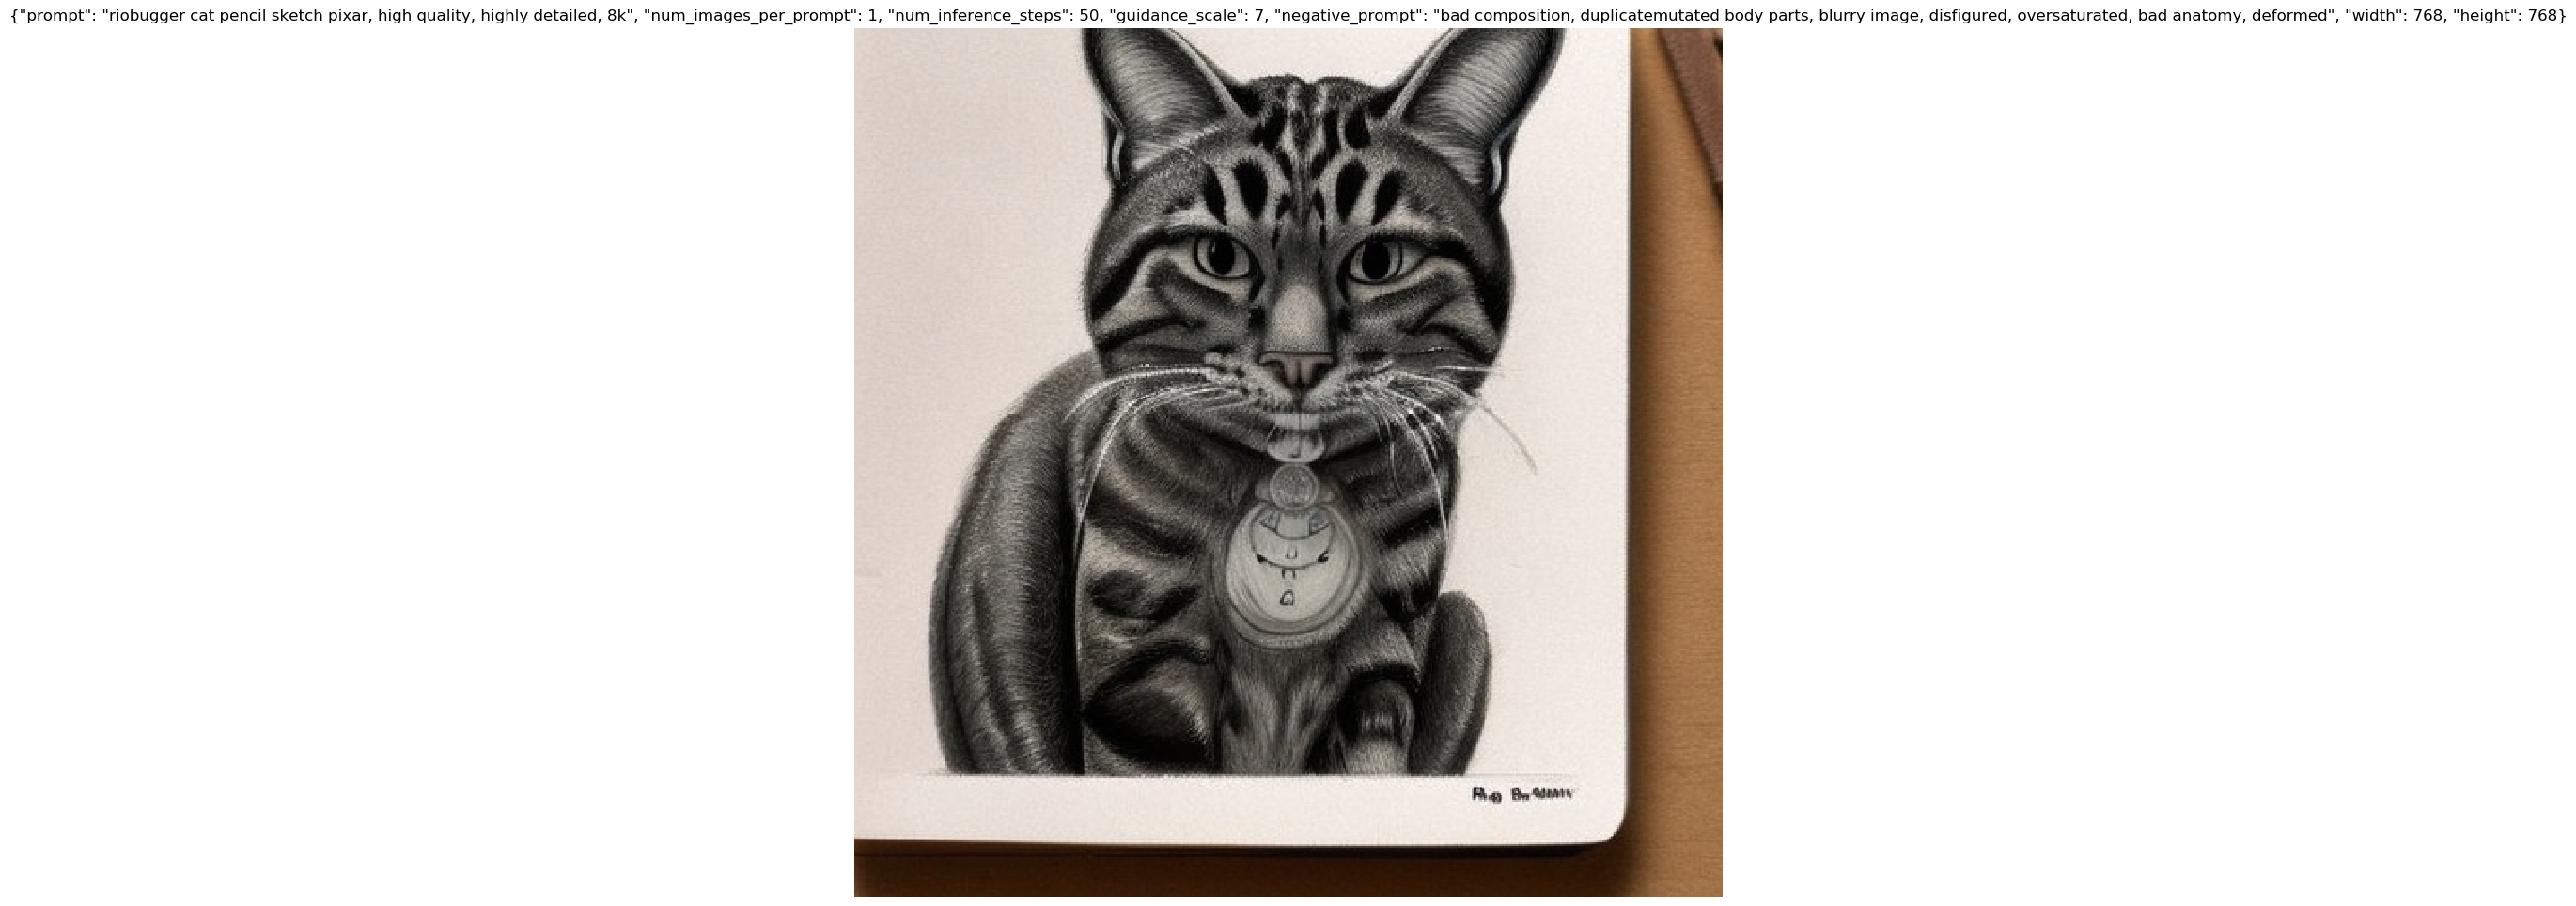

CPU times: user 989 ms, sys: 27.9 ms, total: 1.02 s
Wall time: 26.3 s


In [52]:
%%time

prompt = (
    "riobugger cat pencil sketch pixar,"
    " high quality, highly detailed, 8k" 
)

neg_prompt = ( 
    "bad composition, duplicate"
    "mutated body parts, blurry image, disfigured, oversaturated, bad anatomy, deformed" 
)


payload = {
    'prompt': prompt,
    'num_images_per_prompt': 1, 
    'num_inference_steps': 50, 
    'guidance_scale': 7,
    'negative_prompt': neg_prompt,
    'width': 768,
    'height': 768
}

encoded_payload = json.dumps(payload).encode("utf-8")

content_type = {'ContentType': 'application/x-text', 
             'Accept': 'application/json'}

response = predictor.predict(encoded_payload, content_type)

response = json.loads(response)
img = response['generated_image']
prompt = response['prompt']

plt.figure(figsize=(12, 12))
plt.imshow(np.array(img))
plt.axis('off')
plt.title(prompt)
plt.show()

#### VIII. Invoke the endpoint for inference using SageMaker run-time client (Alternative)

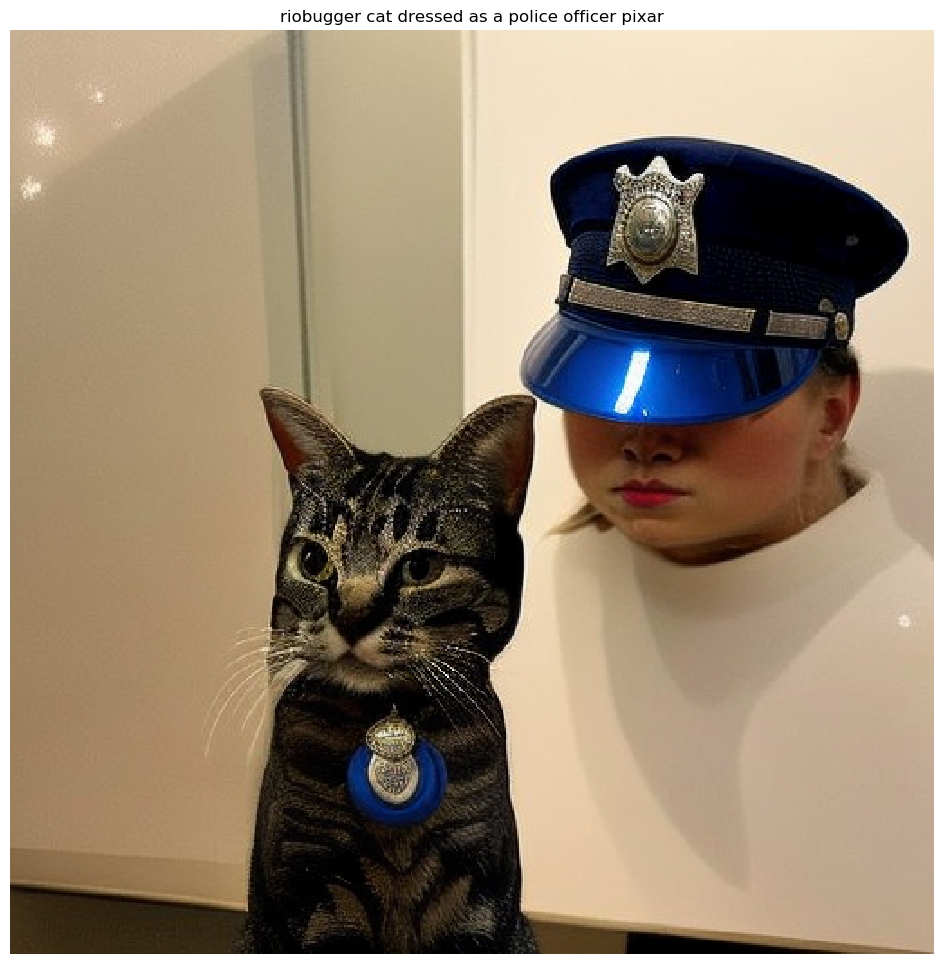

CPU times: user 957 ms, sys: 4 ms, total: 961 ms
Wall time: 25.9 s


In [54]:
%%time

prompt = 'riobugger cat dressed as a police officer pixar'

client = boto3.client('sagemaker-runtime')

response = client.invoke_endpoint(
    EndpointName=endpoint_name, 
    Body=prompt, 
    ContentType='application/x-text'
)

response_body = json.loads(response['Body'].read().decode())
generated_image = response_body['generated_image']

plt.figure(figsize=(12, 12))
plt.imshow(np.array(generated_image))
plt.axis('off')
plt.title(prompt)
plt.show()

In [56]:
# Delete endpoint to save costs
predictor.delete_endpoint()

Deleting endpoint configuration with name: js-ep-20230318162227
Deleting endpoint with name: js-ep-20230318162227
